### Load and split data

In [3]:
df = pd.read_parquet('/vol/sandeep_storage/Files2/catastrophe/era5_temp_precip_daily_2020_2024.parquet')
df


,valid_time,latitude,longitude,t2m,tp
0,2020-01-01,17.0,75.00,24.108643,0.000027
1,2020-01-01,17.0,75.25,24.710449,0.000024
2,2020-01-01,17.0,75.50,25.029602,0.000025
3,2020-01-01,17.0,75.75,25.409241,0.000033
4,2020-01-01,17.0,76.00,25.478027,0.000016
...,...,...,...,...,...
2786170,2024-12-31,23.0,89.00,18.370575,0.000000
2786171,2024-12-31,23.0,89.25,18.370331,0.000000
2786172,2024-12-31,23.0,89.50,18.427368,0.000000
2786173,2024-12-31,23.0,89.75,18.472717,0.000000


In [4]:
df['tp'].values


array([2.6961168e-05, 2.3643175e-05, 2.4596849e-05, ..., 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00], dtype=float32)

In [5]:
import pandas as pd
import numpy as np

# --------------------------
# 1. Load ERA5 data
# --------------------------
df = pd.read_parquet('/vol/sandeep_storage/Files2/catastrophe/era5_temp_precip_daily_2020_2024.parquet')
df["valid_time"] = pd.to_datetime(df["valid_time"])

# --------------------------
# 2. Sort and group for next-day target
# --------------------------
df = df.sort_values(["latitude", "longitude", "valid_time"]).reset_index(drop=True)
g = df.groupby(["latitude", "longitude"])

# --------------------------
# 3. Targets (next-day prediction)
# --------------------------
df["t2m_target"] = g["t2m"].shift(-1)
df["tp_target"]  = g["tp"].shift(-1)

# --------------------------
# 4. Drop incomplete rows
# --------------------------
df = df.dropna().reset_index(drop=True)

# --------------------------
# 5. Standardize both inputs and targets
# --------------------------
# Temperature (t2m)
t2m_mean = df['t2m'].mean()
t2m_std  = df['t2m'].std()
df['t2m'] = (df['t2m'] - t2m_mean) / t2m_std
df['t2m_target'] = (df['t2m_target'] - t2m_mean) / t2m_std

# Precipitation (tp)
tp_mean = df['tp'].mean()
tp_std  = df['tp'].std()
df['tp'] = (df['tp'] - tp_mean) / tp_std
df['tp_target'] = (df['tp_target'] - tp_mean) / tp_std

print("Preprocessing & normalization (standardization) done for inputs and targets. Shape:", df.shape)


Preprocessing & normalization (standardization) done for inputs and targets. Shape: (2784650, 7)


In [6]:
df['tp'].values


array([-0.32872447, -0.37439033, -0.38947797, ..., -0.38947797,
       -0.38947797, -0.38947797], dtype=float32)

In [7]:
# --------------------------
# Split by year (temporal split)
# --------------------------
train_df = df[df["valid_time"].dt.year.isin([2020,2021,2022])]
val_df   = df[df["valid_time"].dt.year == 2023]
test_df  = df[df["valid_time"].dt.year == 2024]

# --------------------------
# Separate t2m and tp datasets
# --------------------------
train_df_t2m = train_df.copy()
val_df_t2m   = val_df.copy()
test_df_t2m  = test_df.copy()

train_df_tp = train_df.copy()
val_df_tp   = val_df.copy()
test_df_tp  = test_df.copy()

print("Train/Val/Test splits ready.")


Train/Val/Test splits ready.


In [8]:
train_df['tp'].values


array([-0.32872447, -0.37439033, -0.38947797, ..., -0.38947797,
       -0.38947797, -0.38947797], dtype=float32)

In [9]:
test_df['tp'].values


array([-0.38947797, -0.38947797, -0.3828967 , ..., -0.38947797,
       -0.38947797, -0.38947797], dtype=float32)

In [10]:
val_df['tp'].values


array([-0.38947797, -0.38947797, -0.38947797, ..., -0.38947797,
       -0.38947797, -0.38401595], dtype=float32)

### ConvLSTM Dataset

In [11]:
import torch
from torch.utils.data import Dataset

class ClimateSeqDataset(Dataset):
    def __init__(self, df, timesteps=7, target_col='t2m_target'):
        """
        df         : DataFrame with columns including latitude, longitude, valid_time, target_col
        timesteps  : Number of previous days in input sequence
        target_col : 't2m_target' or 'tp_target'
        """
        self.df = df.copy()
        self.timesteps = timesteps
        self.target_col = target_col
        
        self.latitudes = np.sort(df['latitude'].unique())
        self.longitudes = np.sort(df['longitude'].unique())
        self.dates = np.sort(df['valid_time'].unique())
        self.n_lat = len(self.latitudes)
        self.n_lon = len(self.longitudes)
        
        # Pivot to (date, grids)
        pivot = df.pivot(index='valid_time', columns=['latitude','longitude'], values=target_col)
        pivot = pivot.ffill().bfill()  # fill missing values
        self.data = pivot.values.astype(np.float32)

    def __len__(self):
        return len(self.data) - self.timesteps

    def __getitem__(self, idx):
        X = self.data[idx:idx+self.timesteps]      # shape (timesteps, grids)
        y = self.data[idx+self.timesteps]          # shape (grids,)
        
        # reshape to (timesteps, 1, lat, lon) and (1, lat, lon)
        X = X.reshape(self.timesteps, 1, self.n_lat, self.n_lon)
        y = y.reshape(1, self.n_lat, self.n_lon)
        return torch.from_numpy(X), torch.from_numpy(y)


### DataLoaders

In [12]:
from torch.utils.data import DataLoader
import torch.nn as nn
import torch

timesteps = 7
batch_size = 4
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ---- DataLoaders ----
train_loader_t2m = DataLoader(ClimateSeqDataset(train_df_t2m, timesteps, 't2m_target'),
                              batch_size=batch_size, shuffle=True)
val_loader_t2m   = DataLoader(ClimateSeqDataset(val_df_t2m, timesteps, 't2m_target'),
                              batch_size=batch_size, shuffle=False)
test_loader_t2m  = DataLoader(ClimateSeqDataset(test_df_t2m, timesteps, 't2m_target'),
                              batch_size=batch_size, shuffle=False)

train_loader_tp = DataLoader(ClimateSeqDataset(train_df_tp, timesteps, 'tp_target'),
                             batch_size=batch_size, shuffle=True)
val_loader_tp   = DataLoader(ClimateSeqDataset(val_df_tp, timesteps, 'tp_target'),
                             batch_size=batch_size, shuffle=False)
test_loader_tp  = DataLoader(ClimateSeqDataset(test_df_tp, timesteps, 'tp_target'),
                             batch_size=batch_size, shuffle=False)

print("DataLoaders ready. Train/Val/Test batches:", 
      len(train_loader_t2m), len(val_loader_t2m), len(test_loader_t2m),
      len(train_loader_tp), len(val_loader_tp), len(test_loader_tp))


DataLoaders ready. Train/Val/Test batches: 273 90 90 273 90 90


### ConvLSTM Model Definition

In [13]:
# ---- ConvLSTM definition ----
class ConvLSTMBlock(nn.Module):
    def __init__(self, in_ch=1, hidden_ch=16, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(in_ch + hidden_ch, hidden_ch, kernel_size, padding=1)
        self.hidden_ch = hidden_ch

    def forward(self, x, h):
        combined = torch.cat([x, h], dim=1)
        h_new = torch.tanh(self.conv(combined))
        return h_new

class ConvLSTM(nn.Module):
    def __init__(self, in_ch=1, hidden_ch=16, kernel_size=3, out_ch=1):
        super().__init__()
        self.hidden_ch = hidden_ch
        self.block = ConvLSTMBlock(in_ch, hidden_ch, kernel_size)
        self.out_conv = nn.Conv2d(hidden_ch, out_ch, kernel_size=1)
        
    def forward(self, x_seq):
        # x_seq: (batch, timesteps, channels, lat, lon)
        b, t, c, h, w = x_seq.shape
        h_t = torch.zeros(b, self.hidden_ch, h, w).to(x_seq.device)
        for ti in range(t):
            h_t = self.block(x_seq[:,ti], h_t)
        out = self.out_conv(h_t)
        return out

# Instantiate models
model_t2m = ConvLSTM(in_ch=1).to(device)
model_tp  = ConvLSTM(in_ch=1).to(device)
print("ConvLSTM models instantiated on", device)


ConvLSTM models instantiated on cpu


### Training Function

### train for t2m

In [14]:
import os
import numpy as np

save_dir = '/vol/sandeep_storage/Files2/catastrophe/convlstm'
os.makedirs(save_dir, exist_ok=True)

def train_model(model, train_loader, val_loader, model_name='t2m', 
                epochs=50, lr=0.001, patience=5, save_dir=save_dir):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    best_val_loss = np.inf
    epochs_no_improve = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            pred = model(X)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for Xv, yv in val_loader:
                Xv, yv = Xv.to(device), yv.to(device)
                pred_v = model(Xv)
                val_loss += criterion(pred_v, yv).item()
        val_loss /= len(val_loader)
        
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            model_path = os.path.join(save_dir, f"best_model_{model_name}.pth")
            torch.save(model.state_dict(), model_path)
            print(f"  -> Best {model_name} model saved at epoch {epoch+1}")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break
    
    # Load best model before returning
    model.load_state_dict(torch.load(model_path))
    return model



In [15]:

model_t2m = train_model(model_t2m, train_loader_t2m, val_loader_t2m, model_name='t2m')


Epoch 1/50 | Train Loss: 0.1287 | Val Loss: 0.0877
  -> Best t2m model saved at epoch 1
Epoch 2/50 | Train Loss: 0.0658 | Val Loss: 0.0636
  -> Best t2m model saved at epoch 2
Epoch 3/50 | Train Loss: 0.0608 | Val Loss: 0.0565
  -> Best t2m model saved at epoch 3
Epoch 4/50 | Train Loss: 0.0603 | Val Loss: 0.0549
  -> Best t2m model saved at epoch 4
Epoch 5/50 | Train Loss: 0.0594 | Val Loss: 0.0555
Epoch 6/50 | Train Loss: 0.0598 | Val Loss: 0.0629
Epoch 7/50 | Train Loss: 0.0580 | Val Loss: 0.0584
Epoch 8/50 | Train Loss: 0.0590 | Val Loss: 0.0548
  -> Best t2m model saved at epoch 8
Epoch 9/50 | Train Loss: 0.0578 | Val Loss: 0.0690
Epoch 10/50 | Train Loss: 0.0579 | Val Loss: 0.0534
  -> Best t2m model saved at epoch 10
Epoch 11/50 | Train Loss: 0.0585 | Val Loss: 0.0561
Epoch 12/50 | Train Loss: 0.0580 | Val Loss: 0.0529
  -> Best t2m model saved at epoch 12
Epoch 13/50 | Train Loss: 0.0578 | Val Loss: 0.0537
Epoch 14/50 | Train Loss: 0.0571 | Val Loss: 0.0583
Epoch 15/50 | Train 

### prediction on  test set

In [37]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import os
import torch

# --------------------------
# Ensure model is in evaluation mode
# --------------------------
model_t2m.eval()

t2m_preds = []

# --------------------------
# 1. Predict on test data
# --------------------------
with torch.no_grad():
    for X_test, _ in test_loader_t2m:
        X_test = X_test.to(device)
        pred = model_t2m(X_test)  # shape: (batch, 1, lat, lon)
        t2m_preds.append(pred.cpu().numpy())

# Concatenate all batches
t2m_preds = np.concatenate(t2m_preds, axis=0)  # shape: (num_samples, 1, lat, lon)

# --------------------------
# 2. Prepare coordinates
# --------------------------
latitudes = np.sort(df['latitude'].unique())
longitudes = np.sort(df['longitude'].unique())
n_lat, n_lon = len(latitudes), len(longitudes)
num_samples = t2m_preds.shape[0]
test_dates = test_df_t2m['valid_time'].unique()  # dates in order

# --------------------------
# 3. Collect records (normalized -> unnormalized)
# --------------------------
records = []
for i in range(num_samples):
    for lat_idx, lat in enumerate(latitudes):
        for lon_idx, lon in enumerate(longitudes):
            # Get normalized true and predicted values
            t2m_true_norm = test_df_t2m.iloc[i*(n_lat*n_lon) + lat_idx*n_lon + lon_idx]['t2m_target']
            t2m_pred_norm = t2m_preds[i, 0, lat_idx, lon_idx]

            # Unnormalize to original units
            t2m_true = t2m_true_norm * t2m_std + t2m_mean
            t2m_pred = t2m_pred_norm * t2m_std + t2m_mean

            # Compute RMSE for this single point (optional: same as absolute error)
            rmse_point = np.sqrt((t2m_true - t2m_pred)**2)

            records.append({
                'date': test_dates[i],
                'latitude': lat,
                'longitude': lon,
                't2m_true': t2m_true,
                't2m_pred': t2m_pred,
                'rmse_t2m': rmse_point
            })

# --------------------------
# 4. Save as parquet
# --------------------------
df_daily_metrics = pd.DataFrame(records)
save_path = os.path.join(save_dir, "convlstm_t2m_daily_grid_metrics.parquet")
df_daily_metrics.to_parquet(save_path, index=False)

print("t2m predictions, true values, and RMSE metrics saved at:", save_path)


t2m predictions, true values, and RMSE metrics saved at: /vol/sandeep_storage/Files2/catastrophe/convlstm/convlstm_t2m_daily_grid_metrics.parquet


In [38]:
test_results=pd.read_parquet('/vol/sandeep_storage/Files2/catastrophe/convlstm/convlstm_t2m_daily_grid_metrics.parquet')
test_results


,date,latitude,longitude,t2m_true,t2m_pred,rmse_t2m
0,2024-01-01,17.0,75.00,24.400940,25.274883,0.873943
1,2024-01-01,17.0,75.25,25.025635,25.152863,0.127228
2,2024-01-01,17.0,75.50,24.663971,25.211798,0.547827
3,2024-01-01,17.0,75.75,24.814087,25.449680,0.635593
4,2024-01-01,17.0,76.00,24.932312,25.574215,0.641903
...,...,...,...,...,...,...
545945,2024-12-23,23.0,89.00,26.818726,20.256889,6.561836
545946,2024-12-23,23.0,89.25,27.520630,20.331778,7.188852
545947,2024-12-23,23.0,89.50,27.928497,20.440292,7.488205
545948,2024-12-23,23.0,89.75,27.474243,20.437256,7.036987


### plot for a day

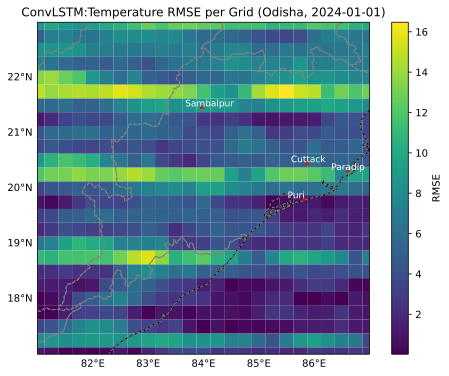

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
# --------------------------
# 1. Load RMSE file
# --------------------------
file_path = '/vol/sandeep_storage/Files2/catastrophe/convlstm/convlstm_t2m_daily_grid_metrics.parquet'
all_metrics = pd.read_parquet(file_path)

# --------------------------
# 2. Function to plot spatial RMSE for Odisha
# --------------------------
def plot_odisha_spatial_map_with_cities(df, metric, title, cmap='viridis'):
    # Filter for Odisha approximate extent
    lat_min, lat_max = 17, 23
    lon_min, lon_max = 81, 87
    df = df[(df['latitude'] >= lat_min) & (df['latitude'] <= lat_max) &
            (df['longitude'] >= lon_min) & (df['longitude'] <= lon_max)]
    
    if df.empty:
        print("No data in the specified extent.")
        return
    
    # Create grid
    lats = np.sort(df['latitude'].unique())
    lons = np.sort(df['longitude'].unique())
    grid = np.full((len(lats), len(lons)), np.nan)
    
    for i, lat in enumerate(lats):
        for j, lon in enumerate(lons):
            val = df[(df['latitude'] == lat) & (df['longitude'] == lon)][metric].values
            if len(val) > 0:
                grid[i, j] = val[0]

# Plot
    fig = plt.figure(figsize=(10,6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    mesh = ax.pcolormesh(lons, lats, grid, shading='auto', cmap=cmap, transform=ccrs.PlateCarree())
    
    # Colorbar
    cbar = fig.colorbar(mesh, ax=ax, orientation='vertical', fraction=0.035, pad=0.04)
    cbar.set_label('RMSE')

    # Map features
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'))
    ax.add_feature(cfeature.BORDERS.with_scale('10m'), linestyle='-', linewidth=1.5)
    ax.add_feature(cfeature.STATES.with_scale('10m'), linestyle='--', edgecolor='gray')

    # Gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.3, alpha=0)
    gl.top_labels = False
    gl.right_labels = False

# City locations
    cities = {
        "Cuttack": (20.46, 85.88),      # flood
        "Paradip": (20.32, 86.61),      # cyclone + flood
        "Puri": (19.81, 85.82),         # cyclone + floo     
        "Sambalpur": (21.47, 83.97)     # heatwave
    }
    for city, (lat, lon) in cities.items():
        # Find nearest available gridpoint
        if df.empty:
            continue
        distances = (df['latitude'] - lat)**2 + (df['longitude'] - lon)**2
        if distances.min() < 1.0:  # threshold to ensure it's "nearby"
            nearest_idx = distances.idxmin()
            nearest_val = df.loc[nearest_idx, metric]
            ax.plot(lon, lat, marker='^', color='red', markersize=3, transform=ccrs.PlateCarree())
            ax.text(lon-0.3, lat+0.01, f"{city}", color='white', fontsize=9, transform=ccrs.PlateCarree())
        else:
            print(f"No nearby grid data for {city}")

    ax.set_title(title)
    plt.show()


    
# --------------------------
# 3. Plot for a specific day
# --------------------------
day_metrics = all_metrics[all_metrics['date'] == '2024-01-01']
plot_odisha_spatial_map_with_cities(day_metrics, 'rmse_t2m', "ConvLSTM:Temperature RMSE per Grid (Odisha, 2024-01-01)")


 GIF saved: odisha_temp_rmse_2024.gif


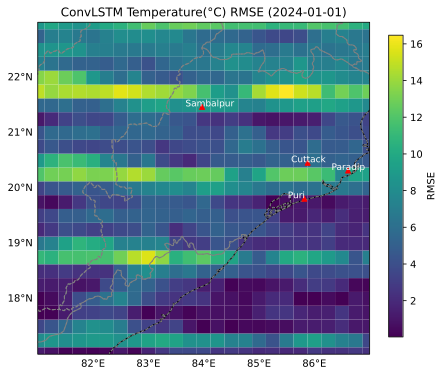

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.animation import FuncAnimation, PillowWriter

# --------------------------
# Function to plot Odisha map for animation
# --------------------------
def plot_odisha_map_for_animation(df, metric, title, cmap='viridis', ax=None):
    lat_min, lat_max = 17, 23
    lon_min, lon_max = 81, 87

    df = df[(df['latitude'] >= lat_min) & (df['latitude'] <= lat_max) &
            (df['longitude'] >= lon_min) & (df['longitude'] <= lon_max)]
    
    if df.empty:
        return

    lats = np.sort(df['latitude'].unique())
    lons = np.sort(df['longitude'].unique())
    grid = np.full((len(lats), len(lons)), np.nan)
    
    for i, lat in enumerate(lats):
        for j, lon in enumerate(lons):
            val = df[(df['latitude'] == lat) & (df['longitude'] == lon)][metric].values
            if len(val) > 0:
                grid[i, j] = val[0]

    if ax is None:
        fig = plt.figure(figsize=(10,6))
        ax = plt.axes(projection=ccrs.PlateCarree())

    ax.clear()
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    mesh = ax.pcolormesh(lons, lats, grid, shading='auto', cmap=cmap, transform=ccrs.PlateCarree())

    # Features
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'))
    ax.add_feature(cfeature.BORDERS.with_scale('10m'), linestyle='-', linewidth=1.5)
    ax.add_feature(cfeature.STATES.with_scale('10m'), linestyle='--', edgecolor='gray')
    
    # Gridlines
    gl = ax.gridlines(draw_labels=True,linewidth=0.3,alpha=0)
    gl.top_labels = False
    gl.right_labels = False

    # Cities
    cities = {
        "Cuttack": (20.46, 85.88),
        "Paradip": (20.32, 86.61),
        "Puri": (19.81, 85.82),
        "Sambalpur": (21.47, 83.97)
    }
    for city, (lat, lon) in cities.items():
        distances = (df['latitude'] - lat)**2 + (df['longitude'] - lon)**2
        if distances.min() < 1.0:
            nearest_idx = distances.idxmin()
            ax.plot(lon, lat, marker='^', color='red', markersize=5, transform=ccrs.PlateCarree())
            ax.text(lon-0.3, lat+0.01, f"{city}", color='white', fontsize=9, transform=ccrs.PlateCarree())

    ax.set_title(title)
    return mesh, ax

# --------------------------
# Animation setup
# --------------------------
dates = pd.to_datetime(np.sort(all_metrics['date'].unique()))  # convert to pandas Timestamp

fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.PlateCarree())
cbar_ax = fig.add_axes([0.77, 0.15, 0.02, 0.7])  # separate colorbar axis

def update(day):
    day_str = dates[day].strftime('%Y-%m-%d')
    day_df = all_metrics[all_metrics['date'] == day_str]
    mesh, _ = plot_odisha_map_for_animation(day_df, 'rmse_t2m', f"ConvLSTM Temperature(°C) RMSE ({day_str})", ax=ax)
    # Add colorbar once
    if day == 0:
        fig.colorbar(mesh, cax=cbar_ax, label='RMSE')

ani = FuncAnimation(fig, update, frames=len(dates), repeat=False)
ani.save('/vol/sandeep_storage/Files2/catastrophe/convlstm/convlstm_odisha_temp_rmse_2024.gif', writer=PillowWriter(fps=3))

print(" GIF saved: odisha_temp_rmse_2024.gif")


---

### train for tp

In [60]:
import os
import numpy as np

save_dir = '/vol/sandeep_storage/Files2/catastrophe/convlstm'
os.makedirs(save_dir, exist_ok=True)

def train_model(model, train_loader, val_loader, model_name='tp', 
                epochs=50, lr=0.001, patience=5, save_dir=save_dir):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    best_val_loss = np.inf
    epochs_no_improve = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            pred = model(X)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for Xv, yv in val_loader:
                Xv, yv = Xv.to(device), yv.to(device)
                pred_v = model(Xv)
                val_loss += criterion(pred_v, yv).item()
        val_loss /= len(val_loader)
        
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            model_path = os.path.join(save_dir, f"best_model_{model_name}.pth")
            torch.save(model.state_dict(), model_path)
            print(f"  -> Best {model_name} model saved at epoch {epoch+1}")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break
    
    # Load best model before returning
    model.load_state_dict(torch.load(model_path))
    return model



In [61]:
model_tp  = train_model(model_tp,  train_loader_tp,  val_loader_tp,  model_name='tp')


Epoch 1/50 | Train Loss: 0.6206 | Val Loss: 0.5874
  -> Best tp model saved at epoch 1
Epoch 2/50 | Train Loss: 0.6205 | Val Loss: 0.5916
Epoch 3/50 | Train Loss: 0.6217 | Val Loss: 0.5956
Epoch 4/50 | Train Loss: 0.6216 | Val Loss: 0.5872
  -> Best tp model saved at epoch 4
Epoch 5/50 | Train Loss: 0.6162 | Val Loss: 0.6043
Epoch 6/50 | Train Loss: 0.6218 | Val Loss: 0.5860
  -> Best tp model saved at epoch 6
Epoch 7/50 | Train Loss: 0.6284 | Val Loss: 0.5882
Epoch 8/50 | Train Loss: 0.6186 | Val Loss: 0.5958
Epoch 9/50 | Train Loss: 0.6184 | Val Loss: 0.5945
Epoch 10/50 | Train Loss: 0.6178 | Val Loss: 0.5897
Epoch 11/50 | Train Loss: 0.6287 | Val Loss: 0.5876
Early stopping triggered at epoch 11


### prediction on  test set

In [62]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import os
import torch

# --------------------------
# Ensure model is in evaluation mode
# --------------------------
model_tp.eval()

tp_preds = []

# --------------------------
# 1. Predict on test data
# --------------------------
with torch.no_grad():
    for X_test, _ in test_loader_tp:
        X_test = X_test.to(device)
        pred = model_tp(X_test)  # shape: (batch, 1, lat, lon)
        tp_preds.append(pred.cpu().numpy())

# Concatenate all batches
tp_preds = np.concatenate(tp_preds, axis=0)  # shape: (num_samples, 1, lat, lon)

# --------------------------
# 2. Prepare coordinates
# --------------------------
latitudes = np.sort(df['latitude'].unique())
longitudes = np.sort(df['longitude'].unique())
n_lat, n_lon = len(latitudes), len(longitudes)
num_samples = tp_preds.shape[0]
test_dates = test_df_tp['valid_time'].unique()  # dates in order

# --------------------------
# 3. Collect records (normalized -> unnormalized)
# --------------------------
records = []
for i in range(num_samples):
    for lat_idx, lat in enumerate(latitudes):
        for lon_idx, lon in enumerate(longitudes):
            # Get normalized true and predicted values
            tp_true_norm = test_df_tp.iloc[i*(n_lat*n_lon) + lat_idx*n_lon + lon_idx]['tp_target']
            tp_pred_norm = tp_preds[i, 0, lat_idx, lon_idx]

            # Unnormalize to original units
            tp_true = tp_true_norm * tp_std + tp_mean
            tp_pred = tp_pred_norm * tp_std + tp_mean

            # Compute RMSE for this single point (optional: same as absolute error)
            rmse_point = np.sqrt((tp_true - tp_pred)**2)

            records.append({
                'date': test_dates[i],
                'latitude': lat,
                'longitude': lon,
                'tp_true': tp_true,
                'tp_pred': tp_pred,
                'rmse_tp_conv': rmse_point
            })

# --------------------------
# 4. Save as parquet
# --------------------------
df_daily_metrics = pd.DataFrame(records)
save_path = os.path.join(save_dir, "convlstm_tp_daily_grid_metrics.parquet")
df_daily_metrics.to_parquet(save_path, index=False)

print("tp predictions, true values, and RMSE metrics saved at:", save_path)


tp predictions, true values, and RMSE metrics saved at: /vol/sandeep_storage/Files2/catastrophe/convlstm/convlstm_tp_daily_grid_metrics.parquet


In [63]:
test_results=pd.read_parquet('/vol/sandeep_storage/Files2/catastrophe/convlstm/convlstm_tp_daily_grid_metrics.parquet')
test_results


,date,latitude,longitude,tp_true,tp_pred,rmse_tp_conv
0,2024-01-01,17.0,81.00,0.000000e+00,0.000108,0.000108
1,2024-01-01,17.0,81.25,2.920628e-06,0.000066,0.000063
2,2024-01-01,17.0,81.50,2.165631e-06,0.000057,0.000055
3,2024-01-01,17.0,81.75,1.072884e-05,0.000046,0.000035
4,2024-01-01,17.0,82.00,1.692772e-05,0.000045,0.000028
...,...,...,...,...,...,...
223745,2024-12-23,23.0,86.00,0.000000e+00,0.000043,0.000043
223746,2024-12-23,23.0,86.25,4.768372e-07,0.000039,0.000039
223747,2024-12-23,23.0,86.50,1.237790e-05,0.000038,0.000025
223748,2024-12-23,23.0,86.75,1.477599e-04,0.000037,0.000111


### plot for a day

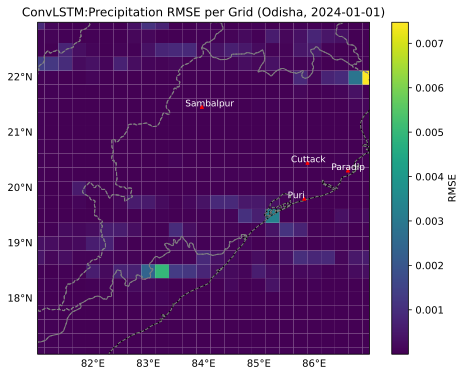

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
# --------------------------
# 1. Load RMSE file
# --------------------------
file_path = '/vol/sandeep_storage/Files2/catastrophe/convlstm/convlstm_tp_daily_grid_metrics.parquet'
all_metrics = pd.read_parquet(file_path)

# --------------------------
# 2. Function to plot spatial RMSE for Odisha
# --------------------------
def plot_odisha_spatial_map_with_cities(df, metric, title, cmap='viridis'):
    # Filter for Odisha approximate extent
    lat_min, lat_max = 17, 23
    lon_min, lon_max = 81, 87
    df = df[(df['latitude'] >= lat_min) & (df['latitude'] <= lat_max) &
            (df['longitude'] >= lon_min) & (df['longitude'] <= lon_max)]
    
    if df.empty:
        print("No data in the specified extent.")
        return
    
    # Create grid
    lats = np.sort(df['latitude'].unique())
    lons = np.sort(df['longitude'].unique())
    grid = np.full((len(lats), len(lons)), np.nan)
    
    for i, lat in enumerate(lats):
        for j, lon in enumerate(lons):
            val = df[(df['latitude'] == lat) & (df['longitude'] == lon)][metric].values
            if len(val) > 0:
                grid[i, j] = val[0]

# Plot
    fig = plt.figure(figsize=(10,6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    mesh = ax.pcolormesh(lons, lats, grid, shading='auto', cmap=cmap, transform=ccrs.PlateCarree())
    
    # Colorbar
    cbar = fig.colorbar(mesh, ax=ax, orientation='vertical', fraction=0.035, pad=0.04)
    cbar.set_label('RMSE')

    # Map features
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'))
    ax.add_feature(cfeature.BORDERS.with_scale('10m'), linestyle='-', linewidth=1.5)
    ax.add_feature(cfeature.STATES.with_scale('10m'), linestyle='--', edgecolor='gray')

    # Gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.3, alpha=0)
    gl.top_labels = False
    gl.right_labels = False

# City locations
    cities = {
        "Cuttack": (20.46, 85.88),      # flood
        "Paradip": (20.32, 86.61),      # cyclone + flood
        "Puri": (19.81, 85.82),         # cyclone + floo     
        "Sambalpur": (21.47, 83.97)     # heatwave
    }
    for city, (lat, lon) in cities.items():
        # Find nearest available gridpoint
        if df.empty:
            continue
        distances = (df['latitude'] - lat)**2 + (df['longitude'] - lon)**2
        if distances.min() < 1.0:  # threshold to ensure it's "nearby"
            nearest_idx = distances.idxmin()
            nearest_val = df.loc[nearest_idx, metric]
            ax.plot(lon, lat, marker='^', color='red', markersize=3, transform=ccrs.PlateCarree())
            ax.text(lon-0.3, lat+0.01, f"{city}", color='white', fontsize=9, transform=ccrs.PlateCarree())
        else:
            print(f"No nearby grid data for {city}")

    ax.set_title(title)
    plt.show()


    
# --------------------------
# 3. Plot for a specific day
# --------------------------
day_metrics = all_metrics[all_metrics['date'] == '2024-01-01']
plot_odisha_spatial_map_with_cities(day_metrics, 'rmse_tp_conv', "ConvLSTM:Precipitation RMSE per Grid (Odisha, 2024-01-01)")


 GIF saved: odisha_tp_rmse_2024.gif


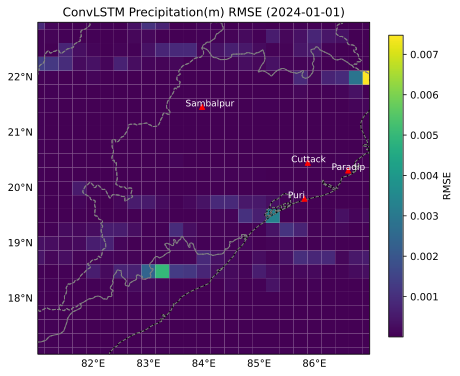

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.animation import FuncAnimation, PillowWriter

# --------------------------
# Function to plot Odisha map for animation
# --------------------------
def plot_odisha_map_for_animation(df, metric, title, cmap='viridis', ax=None):
    lat_min, lat_max = 17, 23
    lon_min, lon_max = 81, 87

    df = df[(df['latitude'] >= lat_min) & (df['latitude'] <= lat_max) &
            (df['longitude'] >= lon_min) & (df['longitude'] <= lon_max)]
    
    if df.empty:
        return

    lats = np.sort(df['latitude'].unique())
    lons = np.sort(df['longitude'].unique())
    grid = np.full((len(lats), len(lons)), np.nan)
    
    for i, lat in enumerate(lats):
        for j, lon in enumerate(lons):
            val = df[(df['latitude'] == lat) & (df['longitude'] == lon)][metric].values
            if len(val) > 0:
                grid[i, j] = val[0]

    if ax is None:
        fig = plt.figure(figsize=(10,6))
        ax = plt.axes(projection=ccrs.PlateCarree())

    ax.clear()
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    mesh = ax.pcolormesh(lons, lats, grid, shading='auto', cmap=cmap, transform=ccrs.PlateCarree())

    # Features
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'))
    ax.add_feature(cfeature.BORDERS.with_scale('10m'), linestyle='-', linewidth=1.5)
    ax.add_feature(cfeature.STATES.with_scale('10m'), linestyle='--', edgecolor='gray')
    
    # Gridlines
    gl = ax.gridlines(draw_labels=True,linewidth=0.3,alpha=0)
    gl.top_labels = False
    gl.right_labels = False

    # Cities
    cities = {
        "Cuttack": (20.46, 85.88),
        "Paradip": (20.32, 86.61),
        "Puri": (19.81, 85.82),
        "Sambalpur": (21.47, 83.97)
    }
    for city, (lat, lon) in cities.items():
        distances = (df['latitude'] - lat)**2 + (df['longitude'] - lon)**2
        if distances.min() < 1.0:
            nearest_idx = distances.idxmin()
            ax.plot(lon, lat, marker='^', color='red', markersize=5, transform=ccrs.PlateCarree())
            ax.text(lon-0.3, lat+0.01, f"{city}", color='white', fontsize=9, transform=ccrs.PlateCarree())

    ax.set_title(title)
    return mesh, ax

# --------------------------
# Animation setup
# --------------------------
dates = pd.to_datetime(np.sort(all_metrics['date'].unique()))  # convert to pandas Timestamp

fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.PlateCarree())
cbar_ax = fig.add_axes([0.77, 0.15, 0.02, 0.7])  # separate colorbar axis

def update(day):
    day_str = dates[day].strftime('%Y-%m-%d')
    day_df = all_metrics[all_metrics['date'] == day_str]
    mesh, _ = plot_odisha_map_for_animation(day_df, 'rmse_tp_conv', f"ConvLSTM Precipitation(m) RMSE ({day_str})", ax=ax)
    # Add colorbar once
    if day == 0:
        fig.colorbar(mesh, cax=cbar_ax, label='RMSE')

ani = FuncAnimation(fig, update, frames=len(dates), repeat=False)
ani.save('/vol/sandeep_storage/Files2/catastrophe/convlstm/convlstm_odisha_preci_rmse_2024.gif', writer=PillowWriter(fps=3))

print(" GIF saved: odisha_tp_rmse_2024.gif")


---